# ДЗ 6. Градиентный бустинг (AdaBoost)

## Графики зависимости ошибки

Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [42]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [43]:
# Используем один из "игрушечных" датасетов из той же библиотеки

X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [44]:
# Разделим выборку на обучающую и тестовую в соотношении 75/25

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [45]:
# Функция, реализующая предсказание в градиентном бустинге

def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    # predictions = np.array(
    # [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    # )

    return predictions

In [46]:
# В качестве функционала ошибки будем использовать среднеквадратичную ошибку

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [47]:
# Производная по z

def residual(y, z):
    return - (z - y)

In [48]:
# Реализуем функцию обучения градиентного бустинга

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [49]:
# Число деревьев в ансамбле
n_trees = [i for i in range(0, 35, 5)]

# Максимальная глубина деревьев
max_depth = 1

# Шаг
eta = 1

In [50]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)
    # ИЗМЕНЕНИЯ ---
    mse_train = mean_squared_error(y_train, train_prediction)
    # ИЗМЕНЕНИЯ ---

    test_prediction = gb_predict(X_test, trees, eta)
    # ИЗМЕНЕНИЯ ---
    mse_test = mean_squared_error(y_test, test_prediction)
    # ИЗМЕНЕНИЯ ---
    
    return mse_train, mse_test

In [51]:
# Обучим несколько моделей с разными параметрами

train_err = []
test_err = []

for j in n_trees:
    trees, train_errors, test_errors = gb_fit(j, max_depth, X_train, X_test, y_train, y_test, eta)
    ea = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(ea[0])
    test_err.append(ea[1])

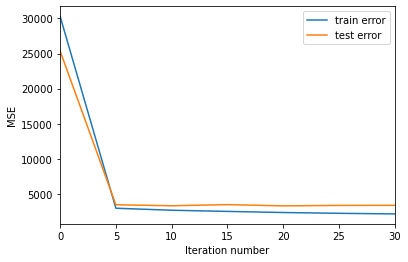

In [52]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees[-1])
plt.plot(n_trees, train_err, label='train error')
plt.plot(n_trees, test_err, label='test error')
plt.legend(loc='upper right')
plt.show()

In [53]:
df_trees = pd.DataFrame({'trees':n_trees, 'train_err':np.round(train_err, 2), 'test_err':np.round(test_err, 2)})
df_trees

,trees,train_err,test_err
0,0,30314.41,25377.03
1,5,2961.97,3457.56
2,10,2675.07,3310.96
3,15,2508.51,3477.63
4,20,2350.76,3295.77
5,25,2236.82,3363.41
6,30,2150.72,3372.75


**Вывод:** При увеличении количества деревьев уменьшается средняя квадратичная ошибка, происходит переобучение.

In [54]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = [i for i in range(1, 10)]

# Шаг
eta = 1

In [55]:
# Обучим несколько моделей с разными параметрами

train_err = []
test_err = []

for k in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, k, X_train, X_test, y_train, y_test, eta)
    ea = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(ea[0])
    test_err.append(ea[1])

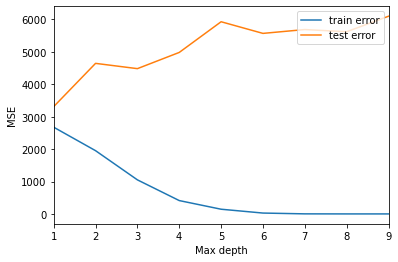

In [56]:
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.xlim(1, max_depth[-1])
plt.plot(max_depth, train_err, label='train error')
plt.plot(max_depth, test_err, label='test error')
plt.legend(loc='upper right')
plt.show()

In [57]:
df_depth = pd.DataFrame({'max_depth':max_depth, 'train_err':np.round(train_err, 2), 'test_err':np.round(test_err, 2)})
df_depth

,max_depth,train_err,test_err
0,1,2675.07,3310.96
1,2,1950.92,4644.63
2,3,1050.74,4481.82
3,4,411.62,4982.07
4,5,144.75,5928.56
5,6,26.38,5569.38
6,7,1.83,5687.88
7,8,0.00,5620.19
8,9,0.00,6098.37


**Вывод:** При увеличении максимальной глубины деверьев происходит быстрое переобучение.

## * Модифицировать реализованный алгоритм градиентного бустинга

Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.